In [1]:
from keras.models import Sequential
from keras.layers import Conv1D, Add, Activation, Dropout, Dense, LSTM, Flatten, MaxPooling1D
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from PyEMD import CEEMDAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import random 
import warnings
warnings.filterwarnings('ignore')

random.seed(17)

In [20]:
LOOK_BACK = 10
SPLIT = 0.8
EPOCHS = 100
BATCH_SIZE = 100

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
data = yf.download("^GSPC", start="2000-01-01")[["Adj Close"]]
data.columns = ["close"]

[*********************100%***********************]  1 of 1 completed


In [5]:
def get_CEEMD_residue(data: pd.DataFrame):
    """
    Complete Ensemble EMD with Adaptive Noise (CEEMDAN) performs an EEMD
    The difference is that the information about the noise is shared among all workers

    :returns:
    IMFs : numpy array
        All the Intrinsic Mode Functions that make up the original stock price
    residue : numpy array
        The residue from the recently analyzed stock price
    """
    
    data_np = data.to_numpy()
    
    ceemd = CEEMDAN()
    ceemd.extrema_detection="parabol"
    ceemd.ceemdan(data_np)
    IMFs, residue = ceemd.get_imfs_and_residue()

    nIMFs = IMFs.shape[0]
    
    plt.figure(figsize=(18,12))
    plt.subplot(nIMFs + 2, 1, 1)

    plt.plot(data, 'r')
    plt.ylabel("S&P500")

    plt.subplot(nIMFs + 2, 1, nIMFs + 2)
    plt.plot(data.index, residue)
    plt.ylabel("Residue")

    for n in range(nIMFs):
        plt.subplot(nIMFs + 2, 1, n + 2)
        plt.plot(data.index, IMFs[n], 'g')
        plt.ylabel("eIMF %i" % (n + 1))
        plt.locator_params(axis='y', nbins=4)
 
    plt.tight_layout()
    plt.show()
    
    return IMFs, residue, nIMFs

def plot_IMFs(IMFs: np.ndarray, residue: np.ndarray, num_IMFs: int, data: pd.DataFrame):
    """
    This function aims to reconstruct the Time Series using the IMFs

    :param IMFs: The IMFs returned from using any of the decomposition functions above
    :param residue: The residue returned from using any of the decomposition functions above
    :param num_IMFs: The number of IMFs you want to reconstruct your data. A value of 2 means the last two IMFs
    :return: None
    """

    sum_IMFs = sum(IMFs[-num_IMFs:])
    sum_IMFs += residue

    plt.figure(figsize=(12, 10))
    plt.plot(data.index, data, label="Stock Price")
    plt.plot(data.index, sum_IMFs, label=f"Last {num_IMFs} IMFs")
    plt.legend(loc="upper left")
    plt.show()

In [21]:
def create_dataset(dataset):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - LOOK_BACK - 1):
        
        look_back_data = dataset[i:(i + LOOK_BACK), 0]
        dataX.append(look_back_data)
        dataY.append(dataset[i + LOOK_BACK, 0])
        
    return np.array(dataX), np.array(dataY)

def LSTM_CNN_CBAM(dataset, layer = 128):
    
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
  
   # Normalize the data -- using Min and Max values in each subsequence to normalize the values
    scaler = MinMaxScaler()
    dataset = scaler.fit_transform(dataset)
  
   # Split data into training and testing set
    train_size = int(len(dataset) * SPLIT)
    test_size = len(dataset) - train_size
    train, test = dataset[:train_size, :], dataset[train_size:, :]
  
    trainX, trainY = create_dataset(train)
    testX, testY = create_dataset(test)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  # create and fit the LSTM-CNN-CBAM network
    model = Sequential()
    model.add(LSTM(layer, input_shape=(1, LOOK_BACK), return_sequences=True))
    model.add(Conv1D(filters = 512, kernel_size = 1, activation='relu', input_shape = (1, LOOK_BACK)))
    model.add(MaxPooling1D(pool_size = 1))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.fit(trainX, trainY, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1, validation_split = 0.1)

  # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

  # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    testing_error = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

    return testPredict, testY, testing_error

def run_model(IMFs):
    
    IMF_predict_list = []
    error_list = []

    for i, IMF in enumerate(IMFs):

        print(f"IMF number {i+1}")
        
        IMF_predict, IMF_test, testing_error = LSTM_CNN_CBAM(IMF, layer = 128)
        error_list.append(testing_error)
        IMF_predict_list.append(IMF_predict)
        
    return IMF_predict_list, error_list


def visualize_results(IMF_predict_list, error_list):
        
    for i, v in enumerate(IMF_predict_list):
        
        IMF_predict_list[i] = v[:, 0]
    
    final_prediction = []
    for i in range(len(IMF_predict_list[0])):

        element = 0 
        
        for j in range(len(IMF_predict_list)):
            
            element += IMF_predict_list[j][i]
            
        final_prediction.append(element)
        
    data_plot = data.close.astype("float32")
    data_plot = np.reshape(data_plot.to_numpy(), (-1, 1))

    train_size = int(len(data_plot) * SPLIT)
    test_size = len(data_plot) - train_size
    data_plot_train, data_plot_test = data_plot[:train_size], data_plot[train_size:]

    data_plot_testX, data_plot_testY = create_dataset(data_plot_test)

    # Calculate the RMSE
    np.sqrt(mean_squared_error(data_plot_testY.tolist(), final_prediction))
    
    plt.figure(figsize=(18,12))

    # plot lines
    plt.plot(data.index[train_size + LOOK_BACK + 1: ], final_prediction, label = "Predicted Value")
    plt.plot(data.index[train_size + LOOK_BACK + 1: ], data_plot_testY.tolist(), label = "Actual Value")
    plt.legend()
    plt.show()

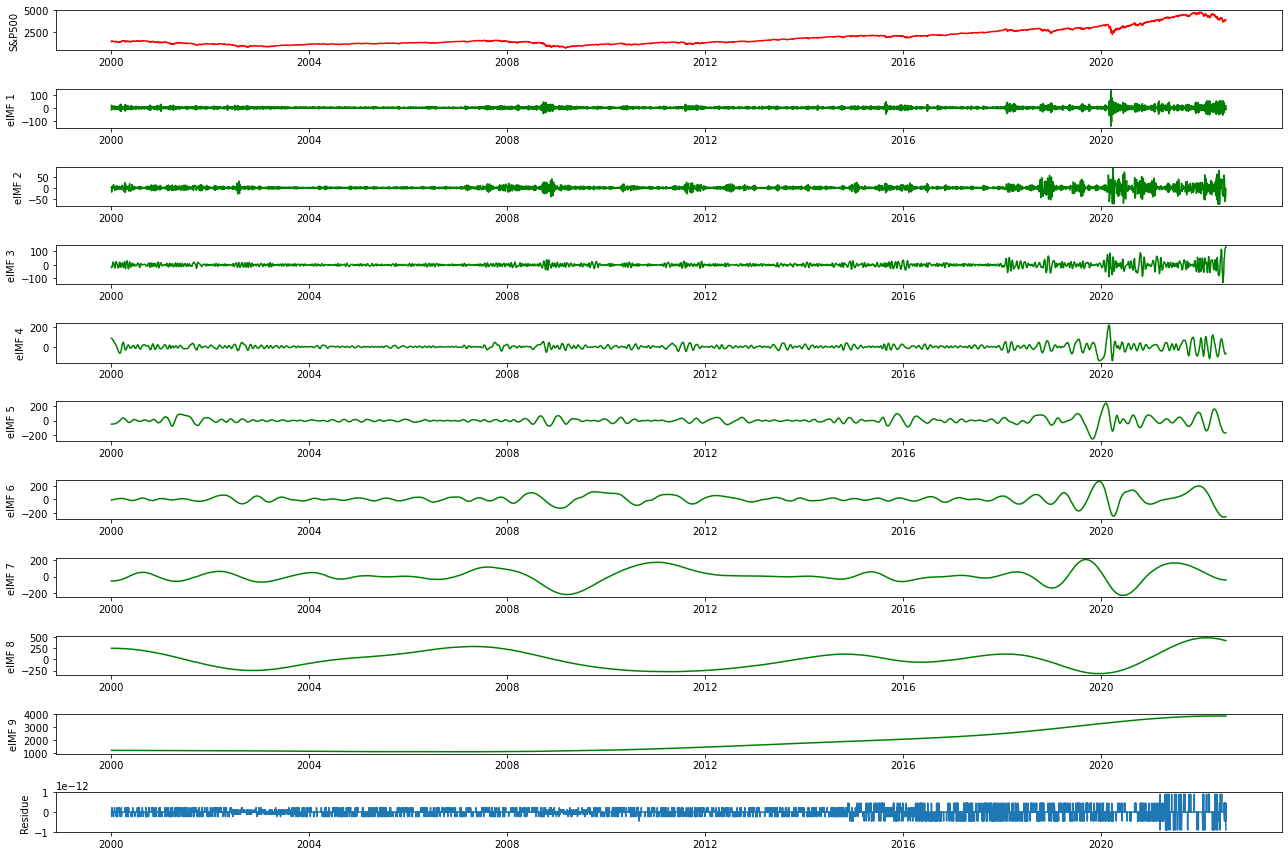

In [17]:
IMFs, residue, n = get_CEEMD_residue(data["close"])

In [22]:
IMF_predict_list, error_list = run_model(IMFs)

IMF number 1
Epoch 1/100
41/41 [==============================] - 3s 27ms/step - loss: 0.0289 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 2/100
41/41 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 4.4165e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
41/41 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 4.4043e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 4.4025e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 4.8542e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 4.3617e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
41/41 [==============================] - 0s 10ms/step - los

41/41 [==============================] - 0s 10ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - val_loss: 4.2330e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
41/41 [==============================] - 0s 9ms/step - loss: 8.8251e-04 - accuracy: 0.0000e+00 - val_loss: 3.5980e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
41/41 [==============================] - 0s 9ms/step - loss: 8.7321e-04 - accuracy: 0.0000e+00 - val_loss: 4.2119e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
41/41 [==============================] - 0s 10ms/step - loss: 9.4394e-04 - accuracy: 0.0000e+00 - val_loss: 3.5896e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
41/41 [==============================] - 0s 10ms/step - loss: 8.6363e-04 - accuracy: 0.0000e+00 - val_loss: 3.4725e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
41/41 [==============================] - 0s 9ms/step - loss: 8.3921e-04 - accuracy: 0.0000e+00 - val_loss: 3.4036e-04 - val_accuracy: 0.0000e+00
Epoch 59/100
41/41 [==============================] - 0s 8ms/step 

Epoch 5/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 5.2371e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 4.6913e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - val_loss: 3.8731e-04 - val_accuracy: 0.0000e+00
Epoch 8/100
41/41 [==============================] - 0s 11ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 5.1444e-04 - val_accuracy: 0.0000e+00
Epoch 9/100
41/41 [==============================] - 0s 8ms/step - loss: 9.9552e-04 - accuracy: 0.0000e+00 - val_loss: 3.5159e-04 - val_accuracy: 0.0000e+00
Epoch 10/100
41/41 [==============================] - 0s 9ms/step - loss: 9.7981e-04 - accuracy: 0.0000e+00 - val_loss: 3.6066e-04 - val_accuracy: 0.0000e+00
Epoch 11/100
41/41 [==============================] - 0s 10ms/step - 

Epoch 57/100
41/41 [==============================] - 1s 12ms/step - loss: 4.7637e-04 - accuracy: 0.0000e+00 - val_loss: 1.6081e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
41/41 [==============================] - 1s 13ms/step - loss: 4.9229e-04 - accuracy: 0.0000e+00 - val_loss: 3.4722e-04 - val_accuracy: 0.0000e+00
Epoch 59/100
41/41 [==============================] - 0s 9ms/step - loss: 5.0203e-04 - accuracy: 0.0000e+00 - val_loss: 1.6700e-04 - val_accuracy: 0.0000e+00
Epoch 60/100
41/41 [==============================] - 0s 11ms/step - loss: 4.8755e-04 - accuracy: 0.0000e+00 - val_loss: 7.5208e-04 - val_accuracy: 0.0000e+00
Epoch 61/100
41/41 [==============================] - 0s 8ms/step - loss: 5.5460e-04 - accuracy: 0.0000e+00 - val_loss: 1.5400e-04 - val_accuracy: 0.0000e+00
Epoch 62/100
41/41 [==============================] - 0s 10ms/step - loss: 4.6824e-04 - accuracy: 0.0000e+00 - val_loss: 2.1210e-04 - val_accuracy: 0.0000e+00
Epoch 63/100
41/41 [============================

Epoch 9/100
41/41 [==============================] - 0s 8ms/step - loss: 6.6161e-04 - accuracy: 0.0000e+00 - val_loss: 1.8018e-04 - val_accuracy: 0.0000e+00
Epoch 10/100
41/41 [==============================] - 0s 8ms/step - loss: 6.1838e-04 - accuracy: 0.0000e+00 - val_loss: 1.6315e-04 - val_accuracy: 0.0000e+00
Epoch 11/100
41/41 [==============================] - 0s 10ms/step - loss: 6.2598e-04 - accuracy: 0.0000e+00 - val_loss: 1.7990e-04 - val_accuracy: 0.0000e+00
Epoch 12/100
41/41 [==============================] - 0s 10ms/step - loss: 5.8300e-04 - accuracy: 0.0000e+00 - val_loss: 1.5055e-04 - val_accuracy: 0.0000e+00
Epoch 13/100
41/41 [==============================] - 0s 9ms/step - loss: 6.0134e-04 - accuracy: 0.0000e+00 - val_loss: 1.3536e-04 - val_accuracy: 0.0000e+00
Epoch 14/100
41/41 [==============================] - 0s 9ms/step - loss: 5.4427e-04 - accuracy: 0.0000e+00 - val_loss: 1.4511e-04 - val_accuracy: 0.0000e+00
Epoch 15/100
41/41 [==============================]

Epoch 61/100
41/41 [==============================] - 0s 10ms/step - loss: 3.1245e-04 - accuracy: 0.0000e+00 - val_loss: 1.8834e-04 - val_accuracy: 0.0000e+00
Epoch 62/100
41/41 [==============================] - 0s 9ms/step - loss: 3.2250e-04 - accuracy: 0.0000e+00 - val_loss: 1.0949e-04 - val_accuracy: 0.0000e+00
Epoch 63/100
41/41 [==============================] - 0s 8ms/step - loss: 2.9926e-04 - accuracy: 0.0000e+00 - val_loss: 8.0298e-05 - val_accuracy: 0.0000e+00
Epoch 64/100
41/41 [==============================] - 1s 13ms/step - loss: 3.1969e-04 - accuracy: 0.0000e+00 - val_loss: 3.0323e-05 - val_accuracy: 0.0000e+00
Epoch 65/100
41/41 [==============================] - 0s 9ms/step - loss: 2.8126e-04 - accuracy: 0.0000e+00 - val_loss: 3.7196e-05 - val_accuracy: 0.0000e+00
Epoch 66/100
41/41 [==============================] - 0s 12ms/step - loss: 2.7965e-04 - accuracy: 0.0000e+00 - val_loss: 1.5516e-04 - val_accuracy: 0.0000e+00
Epoch 67/100
41/41 [=============================

41/41 [==============================] - 0s 8ms/step - loss: 3.4951e-04 - accuracy: 0.0000e+00 - val_loss: 4.5927e-05 - val_accuracy: 0.0000e+00
Epoch 13/100
41/41 [==============================] - 0s 10ms/step - loss: 3.6532e-04 - accuracy: 0.0000e+00 - val_loss: 4.1929e-05 - val_accuracy: 0.0000e+00
Epoch 14/100
41/41 [==============================] - 0s 9ms/step - loss: 3.5001e-04 - accuracy: 0.0000e+00 - val_loss: 5.8796e-05 - val_accuracy: 0.0000e+00
Epoch 15/100
41/41 [==============================] - 0s 8ms/step - loss: 3.3679e-04 - accuracy: 0.0000e+00 - val_loss: 4.7806e-05 - val_accuracy: 0.0000e+00
Epoch 16/100
41/41 [==============================] - 0s 10ms/step - loss: 3.1859e-04 - accuracy: 0.0000e+00 - val_loss: 4.8778e-05 - val_accuracy: 0.0000e+00
Epoch 17/100
41/41 [==============================] - 0s 8ms/step - loss: 3.2483e-04 - accuracy: 0.0000e+00 - val_loss: 4.3857e-05 - val_accuracy: 0.0000e+00
Epoch 18/100
41/41 [==============================] - 0s 10ms/s

41/41 [==============================] - 0s 11ms/step - loss: 1.6445e-04 - accuracy: 0.0000e+00 - val_loss: 2.2668e-05 - val_accuracy: 0.0000e+00
Epoch 64/100
41/41 [==============================] - 1s 14ms/step - loss: 1.6923e-04 - accuracy: 0.0000e+00 - val_loss: 1.3177e-05 - val_accuracy: 0.0000e+00
Epoch 65/100
41/41 [==============================] - 1s 12ms/step - loss: 1.6553e-04 - accuracy: 0.0000e+00 - val_loss: 1.6214e-05 - val_accuracy: 0.0000e+00
Epoch 66/100
41/41 [==============================] - ETA: 0s - loss: 1.5263e-04 - accuracy: 0.0000e+ - 1s 14ms/step - loss: 1.5263e-04 - accuracy: 0.0000e+00 - val_loss: 9.2998e-06 - val_accuracy: 0.0000e+00
Epoch 67/100
41/41 [==============================] - 1s 14ms/step - loss: 1.5730e-04 - accuracy: 0.0000e+00 - val_loss: 6.0076e-06 - val_accuracy: 0.0000e+00
Epoch 68/100
41/41 [==============================] - 1s 13ms/step - loss: 1.6246e-04 - accuracy: 0.0000e+00 - val_loss: 6.0484e-06 - val_accuracy: 0.0000e+00
Epoch 69/

41/41 [==============================] - 0s 8ms/step - loss: 5.2505e-04 - accuracy: 0.0000e+00 - val_loss: 4.8085e-05 - val_accuracy: 0.0000e+00
Epoch 15/100
41/41 [==============================] - 0s 9ms/step - loss: 4.9020e-04 - accuracy: 0.0000e+00 - val_loss: 1.2390e-04 - val_accuracy: 0.0000e+00
Epoch 16/100
41/41 [==============================] - 0s 8ms/step - loss: 4.8105e-04 - accuracy: 0.0000e+00 - val_loss: 4.5820e-05 - val_accuracy: 0.0000e+00
Epoch 17/100
41/41 [==============================] - 0s 8ms/step - loss: 4.7380e-04 - accuracy: 0.0000e+00 - val_loss: 3.8559e-05 - val_accuracy: 0.0000e+00
Epoch 18/100
41/41 [==============================] - 0s 7ms/step - loss: 4.9078e-04 - accuracy: 0.0000e+00 - val_loss: 2.4837e-05 - val_accuracy: 0.0000e+00
Epoch 19/100
41/41 [==============================] - 0s 7ms/step - loss: 4.6818e-04 - accuracy: 0.0000e+00 - val_loss: 3.8561e-05 - val_accuracy: 0.0000e+00
Epoch 20/100
41/41 [==============================] - 0s 7ms/step

Epoch 66/100
41/41 [==============================] - 0s 8ms/step - loss: 3.1617e-04 - accuracy: 0.0000e+00 - val_loss: 1.1989e-05 - val_accuracy: 0.0000e+00
Epoch 67/100
41/41 [==============================] - 0s 7ms/step - loss: 3.0741e-04 - accuracy: 0.0000e+00 - val_loss: 3.5924e-06 - val_accuracy: 0.0000e+00
Epoch 68/100
41/41 [==============================] - 0s 8ms/step - loss: 2.9869e-04 - accuracy: 0.0000e+00 - val_loss: 2.7261e-05 - val_accuracy: 0.0000e+00
Epoch 69/100
41/41 [==============================] - 0s 9ms/step - loss: 2.9911e-04 - accuracy: 0.0000e+00 - val_loss: 6.4689e-06 - val_accuracy: 0.0000e+00
Epoch 70/100
41/41 [==============================] - 0s 7ms/step - loss: 3.1578e-04 - accuracy: 0.0000e+00 - val_loss: 2.8627e-05 - val_accuracy: 0.0000e+00
Epoch 71/100
41/41 [==============================] - 0s 8ms/step - loss: 3.0838e-04 - accuracy: 0.0000e+00 - val_loss: 3.4613e-06 - val_accuracy: 0.0000e+00
Epoch 72/100
41/41 [==============================] 

Epoch 18/100
41/41 [==============================] - 0s 9ms/step - loss: 5.1212e-04 - accuracy: 0.0000e+00 - val_loss: 6.5499e-05 - val_accuracy: 0.0000e+00
Epoch 19/100
41/41 [==============================] - 0s 9ms/step - loss: 5.0704e-04 - accuracy: 0.0000e+00 - val_loss: 9.3998e-05 - val_accuracy: 0.0000e+00
Epoch 20/100
41/41 [==============================] - 0s 9ms/step - loss: 5.0615e-04 - accuracy: 0.0000e+00 - val_loss: 9.6503e-05 - val_accuracy: 0.0000e+00
Epoch 21/100
41/41 [==============================] - 0s 8ms/step - loss: 4.9118e-04 - accuracy: 0.0000e+00 - val_loss: 4.7560e-05 - val_accuracy: 0.0000e+00
Epoch 22/100
41/41 [==============================] - 0s 7ms/step - loss: 4.9158e-04 - accuracy: 0.0000e+00 - val_loss: 4.6890e-05 - val_accuracy: 0.0000e+00
Epoch 23/100
41/41 [==============================] - 0s 7ms/step - loss: 4.7004e-04 - accuracy: 0.0000e+00 - val_loss: 3.7135e-05 - val_accuracy: 0.0000e+00
Epoch 24/100
41/41 [==============================] 

41/41 [==============================] - 0s 8ms/step - loss: 2.9562e-04 - accuracy: 0.0000e+00 - val_loss: 1.1686e-04 - val_accuracy: 0.0000e+00
Epoch 70/100
41/41 [==============================] - 0s 7ms/step - loss: 3.6480e-04 - accuracy: 0.0000e+00 - val_loss: 1.4483e-05 - val_accuracy: 0.0000e+00
Epoch 71/100
41/41 [==============================] - 0s 8ms/step - loss: 2.8167e-04 - accuracy: 0.0000e+00 - val_loss: 6.3747e-06 - val_accuracy: 0.0000e+00
Epoch 72/100
41/41 [==============================] - 0s 8ms/step - loss: 2.5857e-04 - accuracy: 0.0000e+00 - val_loss: 4.1338e-06 - val_accuracy: 0.0000e+00
Epoch 73/100
41/41 [==============================] - 0s 7ms/step - loss: 2.7314e-04 - accuracy: 0.0000e+00 - val_loss: 3.2992e-06 - val_accuracy: 0.0000e+00
Epoch 74/100
41/41 [==============================] - 0s 8ms/step - loss: 2.7464e-04 - accuracy: 0.0000e+00 - val_loss: 1.9577e-06 - val_accuracy: 0.0000e+00
Epoch 75/100
41/41 [==============================] - 0s 9ms/step

Epoch 21/100
41/41 [==============================] - 0s 9ms/step - loss: 5.4396e-04 - accuracy: 0.0000e+00 - val_loss: 1.2294e-05 - val_accuracy: 0.0000e+00
Epoch 22/100
41/41 [==============================] - 0s 8ms/step - loss: 5.5432e-04 - accuracy: 0.0000e+00 - val_loss: 1.0821e-05 - val_accuracy: 0.0000e+00
Epoch 23/100
41/41 [==============================] - 0s 7ms/step - loss: 5.4737e-04 - accuracy: 0.0000e+00 - val_loss: 3.6881e-05 - val_accuracy: 0.0000e+00
Epoch 24/100
41/41 [==============================] - 0s 9ms/step - loss: 5.3988e-04 - accuracy: 0.0000e+00 - val_loss: 4.0978e-05 - val_accuracy: 0.0000e+00
Epoch 25/100
41/41 [==============================] - 0s 7ms/step - loss: 5.4122e-04 - accuracy: 0.0000e+00 - val_loss: 1.8704e-05 - val_accuracy: 0.0000e+00
Epoch 26/100
41/41 [==============================] - 0s 7ms/step - loss: 5.0416e-04 - accuracy: 0.0000e+00 - val_loss: 2.3819e-05 - val_accuracy: 0.0000e+00
Epoch 27/100
41/41 [==============================] 

Epoch 73/100
41/41 [==============================] - 0s 7ms/step - loss: 3.5845e-04 - accuracy: 0.0000e+00 - val_loss: 1.1132e-06 - val_accuracy: 0.0000e+00
Epoch 74/100
41/41 [==============================] - 0s 7ms/step - loss: 3.3045e-04 - accuracy: 0.0000e+00 - val_loss: 2.7711e-06 - val_accuracy: 0.0000e+00
Epoch 75/100
41/41 [==============================] - 0s 7ms/step - loss: 3.6557e-04 - accuracy: 0.0000e+00 - val_loss: 2.3124e-05 - val_accuracy: 0.0000e+00
Epoch 76/100
41/41 [==============================] - 0s 9ms/step - loss: 3.5023e-04 - accuracy: 0.0000e+00 - val_loss: 8.1838e-05 - val_accuracy: 0.0000e+00
Epoch 77/100
41/41 [==============================] - 0s 7ms/step - loss: 3.6116e-04 - accuracy: 0.0000e+00 - val_loss: 4.2777e-06 - val_accuracy: 0.0000e+00
Epoch 78/100
41/41 [==============================] - 0s 8ms/step - loss: 3.2148e-04 - accuracy: 0.0000e+00 - val_loss: 1.9527e-05 - val_accuracy: 0.0000e+00
Epoch 79/100
41/41 [==============================] 

Epoch 25/100
41/41 [==============================] - 0s 9ms/step - loss: 3.0418e-04 - accuracy: 0.0000e+00 - val_loss: 1.0452e-05 - val_accuracy: 0.0000e+00
Epoch 26/100
41/41 [==============================] - 0s 7ms/step - loss: 3.0842e-04 - accuracy: 0.0000e+00 - val_loss: 4.2500e-05 - val_accuracy: 0.0000e+00
Epoch 27/100
41/41 [==============================] - 0s 7ms/step - loss: 3.2394e-04 - accuracy: 0.0000e+00 - val_loss: 3.2664e-06 - val_accuracy: 0.0000e+00
Epoch 28/100
41/41 [==============================] - 0s 9ms/step - loss: 3.1839e-04 - accuracy: 0.0000e+00 - val_loss: 7.1107e-05 - val_accuracy: 0.0000e+00
Epoch 29/100
41/41 [==============================] - 0s 8ms/step - loss: 3.1029e-04 - accuracy: 0.0000e+00 - val_loss: 1.2042e-05 - val_accuracy: 0.0000e+00
Epoch 30/100
41/41 [==============================] - 0s 7ms/step - loss: 3.0614e-04 - accuracy: 0.0000e+00 - val_loss: 2.9249e-06 - val_accuracy: 0.0000e+00
Epoch 31/100
41/41 [==============================] 

Epoch 77/100
41/41 [==============================] - 0s 9ms/step - loss: 2.1650e-04 - accuracy: 0.0000e+00 - val_loss: 1.5577e-05 - val_accuracy: 0.0000e+00
Epoch 78/100
41/41 [==============================] - 0s 7ms/step - loss: 2.2026e-04 - accuracy: 0.0000e+00 - val_loss: 1.5721e-05 - val_accuracy: 0.0000e+00
Epoch 79/100
41/41 [==============================] - 0s 7ms/step - loss: 2.1721e-04 - accuracy: 0.0000e+00 - val_loss: 2.4696e-06 - val_accuracy: 0.0000e+00
Epoch 80/100
41/41 [==============================] - 0s 9ms/step - loss: 2.0790e-04 - accuracy: 0.0000e+00 - val_loss: 3.2695e-06 - val_accuracy: 0.0000e+00
Epoch 81/100
41/41 [==============================] - 0s 8ms/step - loss: 2.0617e-04 - accuracy: 0.0000e+00 - val_loss: 3.2809e-05 - val_accuracy: 0.0000e+00
Epoch 82/100
41/41 [==============================] - 0s 8ms/step - loss: 2.0402e-04 - accuracy: 0.0000e+00 - val_loss: 1.7215e-05 - val_accuracy: 0.0000e+00
Epoch 83/100
41/41 [==============================] 

Epoch 29/100
41/41 [==============================] - 0s 8ms/step - loss: 3.2134e-05 - accuracy: 2.4582e-04 - val_loss: 1.6448e-06 - val_accuracy: 0.0000e+00
Epoch 30/100
41/41 [==============================] - 0s 12ms/step - loss: 2.6093e-05 - accuracy: 2.4582e-04 - val_loss: 8.6742e-06 - val_accuracy: 0.0000e+00
Epoch 31/100
41/41 [==============================] - 0s 8ms/step - loss: 2.8473e-05 - accuracy: 2.4582e-04 - val_loss: 4.1586e-06 - val_accuracy: 0.0000e+00
Epoch 32/100
41/41 [==============================] - 0s 8ms/step - loss: 3.0211e-05 - accuracy: 2.4582e-04 - val_loss: 1.5238e-04 - val_accuracy: 0.0000e+00
Epoch 33/100
41/41 [==============================] - 0s 8ms/step - loss: 2.8331e-05 - accuracy: 2.4582e-04 - val_loss: 7.4260e-06 - val_accuracy: 0.0000e+00
Epoch 34/100
41/41 [==============================] - 0s 8ms/step - loss: 2.9053e-05 - accuracy: 2.4582e-04 - val_loss: 5.9877e-06 - val_accuracy: 0.0000e+00
Epoch 35/100
41/41 [==============================]

Epoch 81/100
41/41 [==============================] - 0s 7ms/step - loss: 2.6372e-05 - accuracy: 2.4582e-04 - val_loss: 7.2000e-05 - val_accuracy: 0.0000e+00
Epoch 82/100
41/41 [==============================] - 0s 9ms/step - loss: 2.7915e-05 - accuracy: 2.4582e-04 - val_loss: 1.8630e-05 - val_accuracy: 0.0000e+00
Epoch 83/100
41/41 [==============================] - 0s 7ms/step - loss: 2.4674e-05 - accuracy: 2.4582e-04 - val_loss: 7.0158e-05 - val_accuracy: 0.0000e+00
Epoch 84/100
41/41 [==============================] - 0s 7ms/step - loss: 2.8701e-05 - accuracy: 2.4582e-04 - val_loss: 1.5861e-05 - val_accuracy: 0.0000e+00
Epoch 85/100
41/41 [==============================] - 0s 9ms/step - loss: 2.4296e-05 - accuracy: 2.4582e-04 - val_loss: 1.3484e-05 - val_accuracy: 0.0000e+00
Epoch 86/100
41/41 [==============================] - 0s 8ms/step - loss: 2.5092e-05 - accuracy: 2.4582e-04 - val_loss: 8.7960e-07 - val_accuracy: 0.0000e+00
Epoch 87/100
41/41 [==============================] 

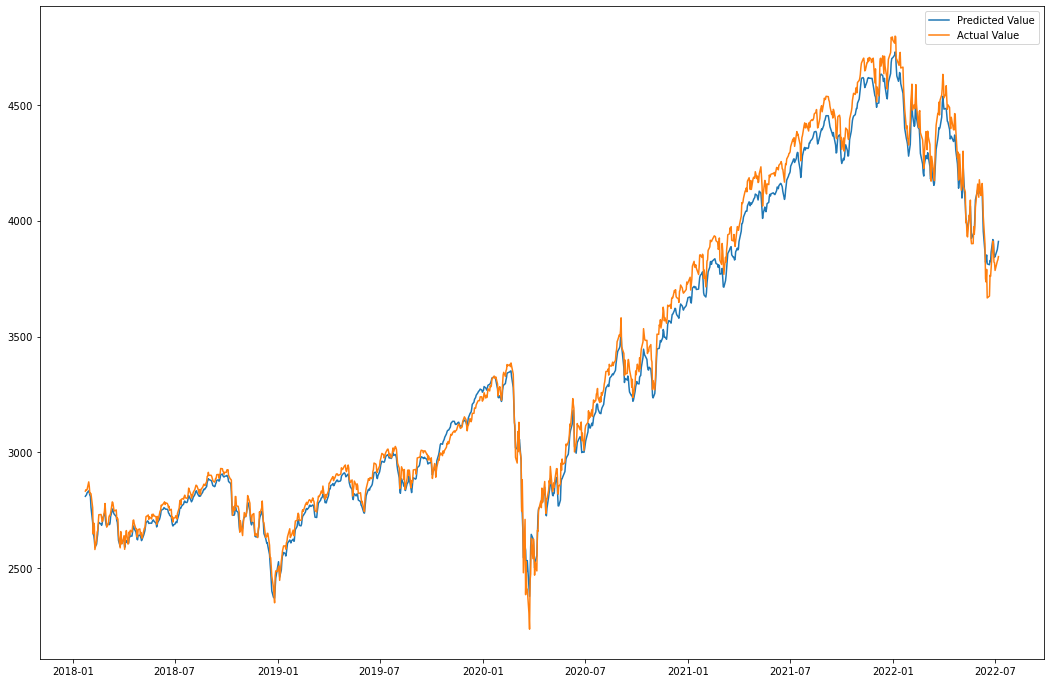

In [23]:
visualize_results(IMF_predict_list, error_list)